In [1]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f'func: {f.__name__} took: {te-ts:.4f} sec')
        return result

    return timed


def load_dataset(path):
    with open(path, 'rb') as f:
        train_data, test_data = pickle.load(f)
    
    X_train = torch.tensor(train_data[0], dtype=torch.float).unsqueeze(1)
    y_train = torch.tensor(train_data[1], dtype=torch.long)
    X_test = torch.tensor(test_data[0], dtype=torch.float).unsqueeze(1)
    y_test = torch.tensor(test_data[1], dtype=torch.long)
    return X_train, y_train, X_test, y_test


class MnistDataset():
    def __init__(self, X, y):
        assert X.shape[0] == y.shape[0]
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

class Trainer:
    
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model
        if opt_method == "sgdm":
            self.optimizer = torch.optim.SGD(model.parameters(), learning_rate, momentum=0.9)
        elif opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
    
    @timeit
    def train(self, train_data, val_data, early_stop=True, verbose=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list, train_acc_list = [], []
        val_loss_list, val_acc_list = [], []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_func = nn.CrossEntropyLoss()
        for n in tqdm(range(self.epoch), leave=False):
            self.model.train()
            for X_batch, y_batch in train_loader:
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
            train_loss, train_acc = self.evaluate(train_data)
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            
            val_loss, val_acc = self.evaluate(val_data)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].plot(x_axis, val_loss_list, label="Validation")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].plot(x_axis, val_acc_list, label='Validation')
            axes[1].set_title("Accuracy")
            axes[1].legend()
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "train_acc_list": train_acc_list,
            "val_loss_list": val_loss_list,
            "val_acc_list": val_acc_list,
        }
    
    def evaluate(self, data, print_acc=False):
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        loss_func = nn.CrossEntropyLoss()
        acc, loss = 0.0, 0.0
        for X_batch, y_batch in loader:
            with torch.no_grad():
                batch_importance = y_batch.shape[0] / len(data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                batch_acc = torch.sum(torch.argmax(y_pred, axis=-1) == y_batch) / y_batch.shape[0]
                acc += batch_acc.detach().cpu().item() * batch_importance
                loss += batch_loss.detach().cpu().item() * batch_importance
        if print_acc:
            print(f"Accuracy: {acc:.3f}")
        return loss, acc
    

def KFoldCrossValidation(
    model_class, k, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=50, l2=0.0,
    early_break=False,
    **model_args
):
    test_data = MnistDataset(X_test, y_test)
    kf = KFold(n_splits=k, shuffle=True)
    train_acc_list, test_acc_list = [], []
    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        print(f"Fold {i}:")
        
        train_data = MnistDataset(X_train[train_index], y_train[train_index])
        val_data = MnistDataset(X_train[val_index], y_train[val_index])
        
        model = model_class(**model_args)
        
        trainer = Trainer(model, opt_method, learning_rate, batch_size, epoch, l2)
        res = trainer.train(train_data, val_data)
        train_acc_best = res['train_acc_list'][np.argmin(res['val_loss_list'])]
        test_loss, test_acc = trainer.evaluate(test_data)
        
        train_acc_list.append(train_acc_best)
        test_acc_list.append(test_acc)
        
        print(f"Training accuracy: {train_acc_best}")
        print(f"Test accuracy: {test_acc}")
        
        if early_break:
            break
    
    if not early_break:
        print("Final results:")
        print(f"Training accuracy: {np.mean(train_acc_list)}+/-{np.std(train_acc_list)}")
        print(f"Test accuracy: {np.mean(test_acc_list)}+/-{np.std(test_acc_list)}")


# Question 1

### For (a) and (b), DO NOT use `torchsummary` package. Please calculate by yourself. 



## (a)

(i) 
output dimension = (n+2p-f)/s + 1 = (33 + 0 - 3)/2 +1 = 16
number of filters = 33

-->(33, 16, 16)

(ii)
output_dim = (16 + 2 - 3)/1 + 1 = 16
--->(55, 16, 16)


(iii)

output_dim = (16+2-3)/1 + 1 = 16
(77, 16, 16)
--> maxpooling: (77, 8, 8)

## (b)

depth = 3 

(i) Convolution Filter size of 2x2, number of filters 33, stride of 2, padding of 0

dimension = (33 - 2)/2 + 1 = 16.5 ~ 16
--> (33, 16,16)

(ii). Convolution Filter size of 3x3, number of filters 55, stride of 1, padding of 1. Followed by a max pooling layer of kernel size 3x3, stride of 1, padding of 0

dim = (16 - 3 + 2) + 1 = 16 --> (55, 16, 16)
maxpooling --> 16-3/1 + 1 = 14 --> (55, 14, 14)

(iii). Convolution Filter size of 3x3, number of filters 77, stride of 1, padding of 1. Followed by a Max Pooling with filter size of 2x2 and stride 2.

dim = (14 - 3 + 2)/2 + 1 = 7
dim = (7 -3)/2 + 1 = 3
--> (77, 3,3)


## (c)

### Instructions: For training stability, it is recommened to normalize the data by dividing its max value as you did in HW6.

In [3]:
# Normalize data
X_train, y_train, X_test, y_test = load_dataset('/Users/mac_1/Desktop/CHEM C142/mnist.pkl')
X_train = X_train/X_train.max()
X_test = X_test/X_test.max()

Fold 0:


func: train took: 86.6491 sec
Training accuracy: 0.9851250000000006
Test accuracy: 0.9696999999999996
Fold 1:


func: train took: 71.8451 sec
Training accuracy: 0.9906250000000005
Test accuracy: 0.9756999999999996
Fold 2:


func: train took: 72.6613 sec
Training accuracy: 0.9889750000000002
Test accuracy: 0.9762999999999992
Final results:
Training accuracy: 0.9882416666666671+/-0.002304464266495636
Test accuracy: 0.9738999999999994+/-0.0029799328851501635


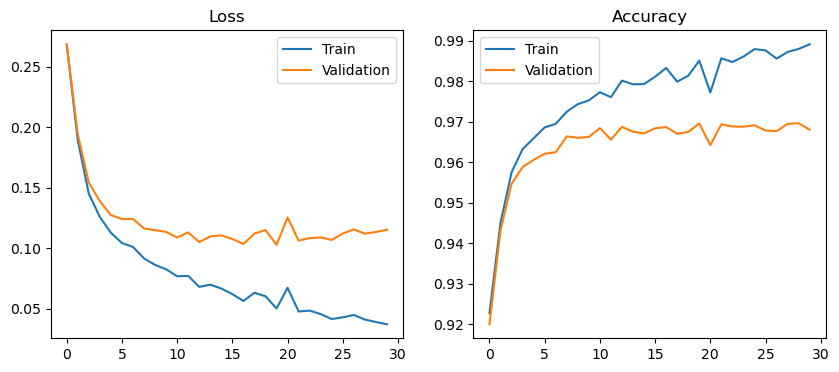

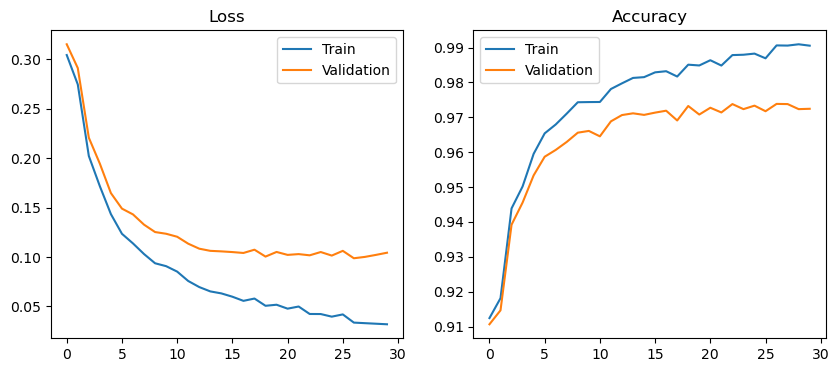

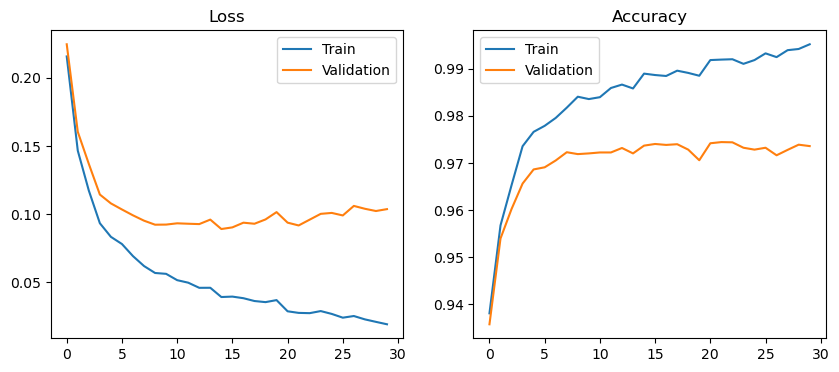

In [10]:
class ShallowCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels =3, kernel_size=5, stride=1, padding=2), # Conv Layer
            nn.ReLU(), # ReLU
            nn.Flatten(), # Flatten
            nn.Linear(3 * 32 * 32, 10), # Linear Layer
        )
    
    def forward(self, x):
        return self.layers(x)
    

KFoldCrossValidation(
    model_class=ShallowCNN,
    k=3,  # Number of folds
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
    opt_method='adam', learning_rate=1e-3, batch_size=128, epoch=30, l2=0.0,
    
)


## (d)

Fold 0:


func: train took: 988.3499 sec
Training accuracy: 0.9959249999999985
Test accuracy: 0.9888000000000001
Fold 1:


func: train took: 980.3795 sec
Training accuracy: 0.9985749999999975
Test accuracy: 0.9906000000000008
Fold 2:


func: train took: 960.2967 sec
Training accuracy: 0.9953749999999987
Test accuracy: 0.9917000000000006
Final results:
Training accuracy: 0.9966249999999982+/-0.0013970206393125616
Test accuracy: 0.9903666666666672+/-0.001195361405136289


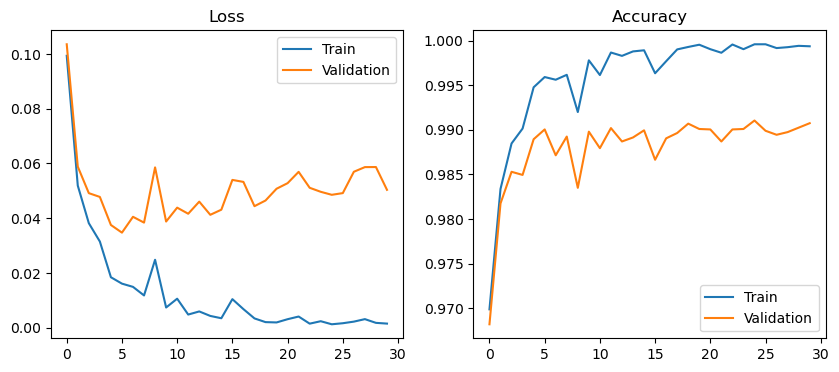

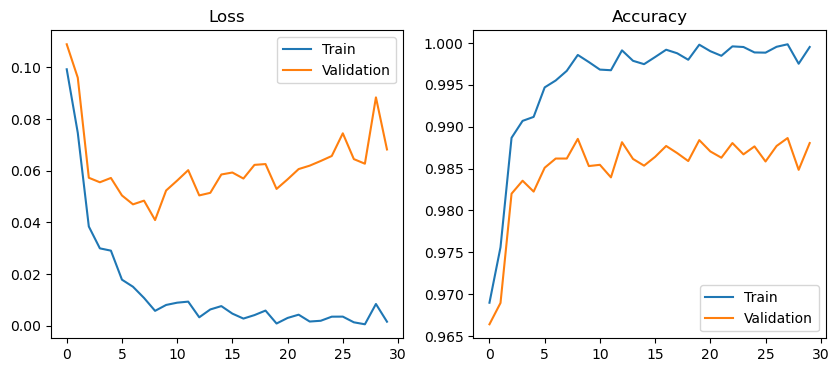

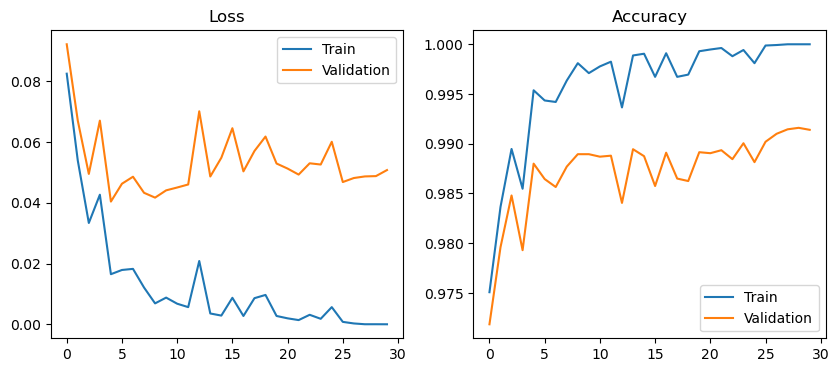

In [11]:
class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.ModuleList([
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Conv Layer 1: Input channels = 1, Output channels = 32
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Conv Layer 2: Input channels = 32, Output channels = 64
        ])
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2) # Pooling
        self.fc = nn.ModuleList([
            nn.Linear(64 * 8 * 8, 128), # Linear Layer 1
            nn.Linear(128, 10) # Linear Layer 2
        ])
        self.activation = nn.ReLU()   # ReLU activation function
        self.flatten = nn.Flatten() # Flatten Layer
        
    def forward(self, x):
        for i in range(2):
            x = self.pooling(self.activation(self.conv[i](x)))
        x = self.flatten(x)
        x = self.activation(self.fc[0](x))
        x = self.fc[1](x)
        return x

KFoldCrossValidation(
    model_class=DeepCNN,
    k=3,  # Number of folds
    X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
    opt_method='adam', learning_rate=1e-3, batch_size=128, epoch=30, l2=0.0,
    
)


# Question 2

### Instructions: You can set `early_break=True` in `KFoldCrossValidation` function to just to a train-validation round instead of doing 3-fold.

## (a)


In [23]:
class ResNet(nn.Module):
    def __init__(self, use_resnet=True, use_batch_norm=True):
        super(ResNet, self).__init__()
        self.conv = nn.ModuleList([
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),  # Conv Layer 1
            nn.Conv2d(6, 12, kernel_size=5, stride=1, padding=0)  # Conv Layer 2
        ])
        self.bn1 = nn.BatchNorm2d(6) if use_batch_norm else nn.Identity()  # Batch Norm 1
        self.bn2 = nn.BatchNorm2d(12) if use_batch_norm else nn.Identity()  # Batch Norm 2
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling
        self.fc = nn.ModuleList([
            nn.Linear(12 * 5 * 5, 300),  # Linear Layer 1
            nn.Linear(300, 10)  # Linear Layer 2
        ])
        self.activation = nn.ReLU()  # ReLU activation function
        self.flatten = nn.Flatten()  # Flatten Layer
        self.use_resnet = use_resnet
        
    def forward(self, x):
        for i in range(2):
            x = self.conv[i](x)
            if hasattr(self, 'use_batch_norm') and self.use_batch_norm:
                x = self.bn1(x) if i == 0 else self.bn2(x)
            x = self.pooling(self.activation(x))

        x = self.flatten(x)
        skip_connection = x  # Creating a skip connection from the flattened layer
        x = self.activation(self.fc[0](x))
        if self.use_resnet:
            x = x + skip_connection  # Additive skip connection to the second fully connected layer
        x = self.fc[1](x)
        return x

Fold 0:


func: train took: 157.3496 sec
Training accuracy: 0.9976499999999981
Test accuracy: 0.9908000000000009


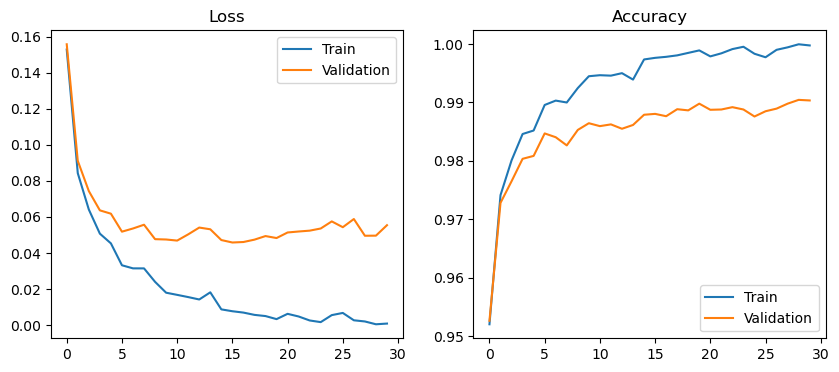

In [24]:
# Run with BatchNorm & Residual
KFoldCrossValidation(
    model_class=ResNet,
    k=3,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    opt_method='adam',
    learning_rate=1e-3,
    batch_size=128,
    epoch=30,
    l2=0.0, 
    early_break=True,
    use_resnet=True, use_batch_norm=True
)

Fold 0:


func: train took: 148.9422 sec
Training accuracy: 0.9972999999999981
Test accuracy: 0.9886


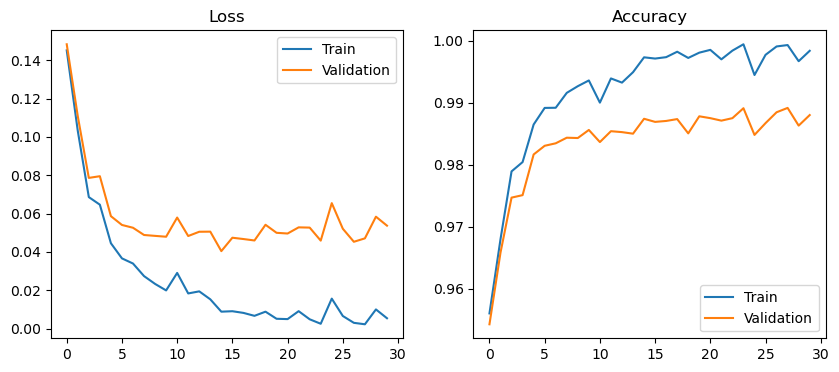

In [25]:
# Run without BatchNorm by setting `use_batch_norm=False`
KFoldCrossValidation(
    model_class=ResNet,
    k=3,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    opt_method='adam',
    learning_rate=1e-3,
    batch_size=128,
    epoch=30,
    l2=0.0,
    early_break=True, 
    use_resnet=True, use_batch_norm=False
)

Based on the result, running with BathchNorm gives out higher accuracy.

## (b)

Fold 0:


func: train took: 52.1025 sec
Training accuracy: 0.9935749999999995
Test accuracy: 0.9860000000000009


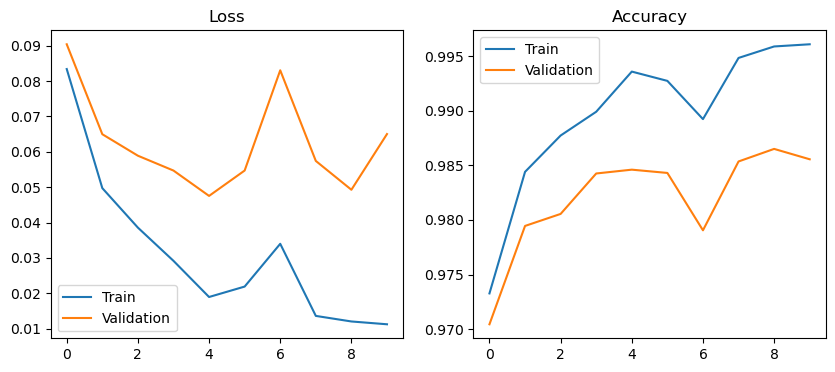

In [29]:
# Run with BatchNorm & Residual
KFoldCrossValidation(
    model_class=ResNet,
    k=3,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    opt_method='adam',
    learning_rate=5e-3,
    batch_size=128,
    epoch=10,
    l2=0.0, 
    early_break=True, 
    use_resnet=True, use_batch_norm=True
)

Fold 0:


func: train took: 49.9296 sec
Training accuracy: 0.9914000000000001
Test accuracy: 0.9866000000000003


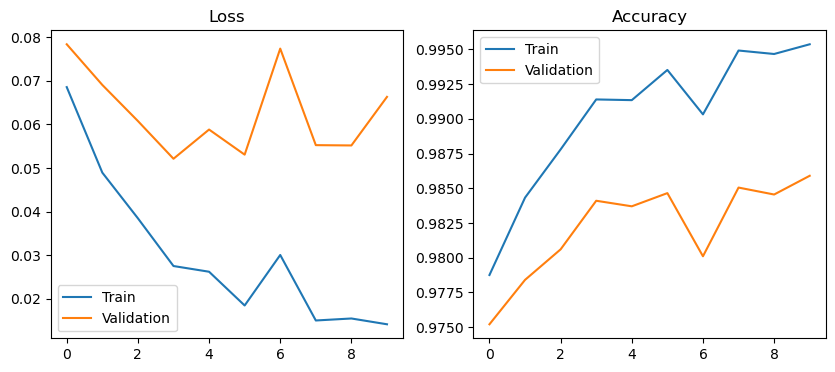

In [30]:
# Run without Residual
KFoldCrossValidation(
    model_class=ResNet,
    k=3,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    opt_method='adam',
    learning_rate=5e-3,
    batch_size=128,
    epoch=10,
    l2=0.0, 
    early_break=True, 
    use_resnet=False, use_batch_norm=True
)

Fold 0:


func: train took: 150.7794 sec
Training accuracy: 0.9951749999999987
Test accuracy: 0.9880000000000003


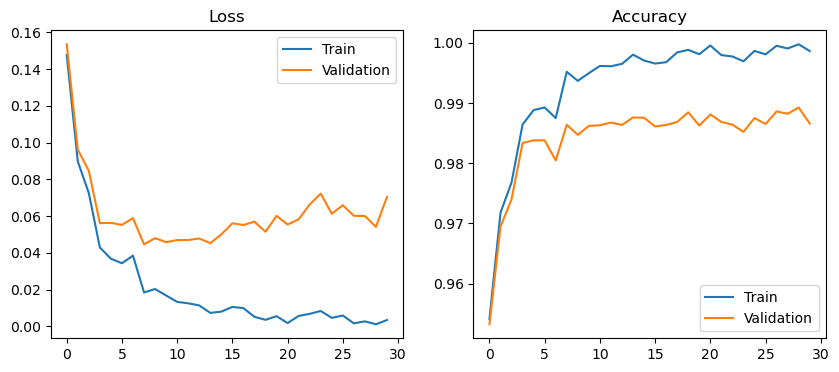

In [31]:
# Run with BatchNorm & Residual
KFoldCrossValidation(
    model_class=ResNet,
    k=3,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    opt_method='adam',
    learning_rate=1e-3,
    batch_size=128,
    epoch=30,
    l2=0.0, 
    early_break=True, 
    use_resnet=True, use_batch_norm=True
)

Fold 0:


func: train took: 147.0229 sec
Training accuracy: 0.993725
Test accuracy: 0.9853000000000003


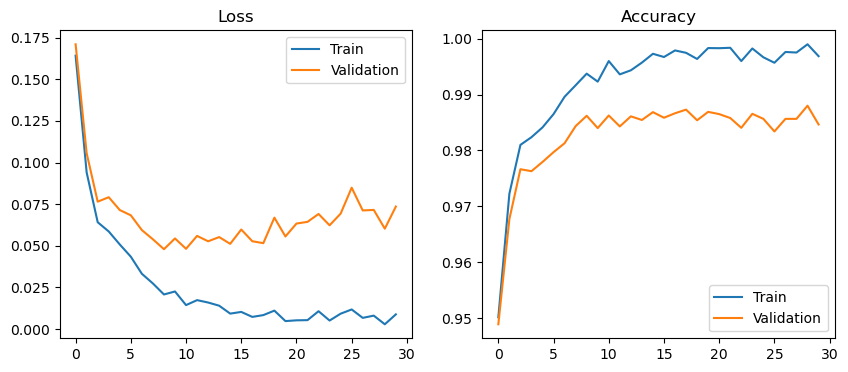

In [32]:
# Run with BatchNorm & Residual
KFoldCrossValidation(
    model_class=ResNet,
    k=3,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    opt_method='adam',
    learning_rate=1e-3,
    batch_size=128,
    epoch=30,
    l2=0.0, 
    early_break=True, 
    use_resnet=False, use_batch_norm=True
)

Running with residual showed faster training and lower test accuracy compared to running without residual.